# Machine Learning with RNA-Seq data

Please find instructions on how to run the code in [README](https://git.imp.fu-berlin.de/vbendikova/dsls-project/-/blob/main/README.md).

In [ ]:
!pip install yellowbrick pycombat --quiet

In [1]:
import pandas as pd
from pathlib import Path
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from yellowbrick.classifier import ROCAUC, ClassificationReport, ConfusionMatrix
from combat.pycombat import pycombat
from imblearn.pipeline import Pipeline as imbpipeline

In [6]:
# Replace with your home path
home = "data/"

# Data Preparation

Load datasets

In [7]:
asd_path = Path(home + "rna-seq/autism/")
mdd_path = Path(home + "rna-seq/depression/")
scz_path = Path(home + "rna-seq/schizophrenia/")

asd_df_path = asd_path / "asd_annotated.csv.gz"
mdd_df_path = mdd_path / "mdd_annotated.csv.gz"
scz_df_path = scz_path / "scz_annotated.csv.gz"

asd_deg_path = asd_path / "asd_deg.csv"
mdd_deg_path = mdd_path / "mdd_deg.csv"
scz_deg_path = scz_path / "scz_deg.csv"

asd_labels_path = asd_path / "asd_groups.csv"
mdd_labels_path = mdd_path / "mdd_groups.csv"
scz_labels_path = scz_path / "scz_groups.csv"

In [8]:
asd_df = pd.read_csv(asd_df_path, compression='gzip', index_col=0).T
mdd_df = pd.read_csv(mdd_df_path, compression='gzip', index_col=0).T
scz_df = pd.read_csv(scz_df_path, compression='gzip', index_col=0).T

asd_deg = pd.read_csv(asd_deg_path, index_col=0)
mdd_deg = pd.read_csv(mdd_deg_path, index_col=0)
scz_deg = pd.read_csv(scz_deg_path, index_col=0)

asd_labels = pd.read_csv(asd_labels_path)
mdd_labels = pd.read_csv(mdd_labels_path)
scz_labels = pd.read_csv(scz_labels_path)

Add class labels

In [9]:
asd_df['class'] = asd_labels['x'].to_list()
mdd_df['class'] = mdd_labels['x'].to_list()
scz_df['class'] = scz_labels['x'].to_list()

Merge datasets

In [10]:
merged_df = pd.concat([asd_df, mdd_df, scz_df])
merged_df

A1BG  A1BG-AS1      A1CF       A2M   A2M-AS1     A2ML1   
GSM627071  6.922376  5.131690  3.824830  3.712371  4.827692  3.443286  \
GSM627072  7.079010  4.973937  3.794067  4.184242  4.845449  3.763105   
GSM627073  6.649284  4.959877  3.431487  4.083371  4.668945  3.238803   
GSM627074  6.704437  5.955316  3.856110  3.989071  4.314766  3.538252   
GSM627075  7.243042  5.451858  3.965673  4.467503  4.757868  3.473222   
...             ...       ...       ...       ...       ...       ...   
GSM677185  7.357270  5.581190  3.994580  4.558590  5.643400  4.131235   
GSM677186  7.426510  5.444330  4.126125  4.463340  6.112250  3.995420   
GSM677187  7.223980  5.245380  4.033050  4.488430  5.286200  4.070210   
GSM677188  7.311390  5.391370  4.009330  4.680990  4.505270  3.915010   
GSM677189  7.262390  5.522200  4.168635  4.388410  6.543010  4.032390   

              A2MP1    A4GALT     A4GNT      AA06  ...      ZXDA   
GSM627071  4.084510  6.453824  4.324094  5.066899  ...  5.766817  \
GSM627072  4.337083  6.524271  4.196970  5.201747  ...  5.912262   
GSM627073  4.297174  6.821242  4.219676  5.123526  ...  5.424710   
GSM627074  4.441767  6.815260  4.234145  5.571078  ...  5.141153   
GSM627075  4.193363  6.670571  4.448624  5.310763  ...  5.688745   
...             ...       ...       ...       ...  ...       ...   
GSM677185  4.242960  6.900960  4.000480  5.066390  ...  6.241840   
GSM677186  4.269960  6.818560  4.144490  4.866710  ...  6.507030   
GSM677187  4.479890  6.812190  4.384700  5.106350  ...  6.338300   
GSM677188  4.475290  6.759410  4.046380  5.138150  ...  6.577920   
GSM677189  4.575350  6.874220  4.192130  5.132170  ...  5.889930   

           ZXDA /// ZXDB      ZXDB      ZXDC    ZYG11A    ZYG11B        ZYX   
GSM627071       4.651581  5.073469  6.914662  4.266653  8.029654  10.877024  \
GSM627072       4.762140  5.174046  6.878319  4.505546  8.409185   9.741187   
GSM627073       4.934804  5.180716  6.985516  3.864035  8.010744  10.000593   
GSM627074       4.532267  4.483348  6.787098  3.836069  7.937970  11.760469   
GSM627075       4.844558  5.428559  6.345608  4.155866  7.720049   9.498757   
...                  ...       ...       ...       ...       ...        ...   
GSM677185       4.913830  6.035155  7.249373  3.989820  9.100350  10.545850   
GSM677186       4.902720  6.012285  7.264483  4.218300  9.188500  10.193450   
GSM677187       4.789980  5.764395  7.156213  4.589760  9.209560  10.349350   
GSM677188       5.233090  6.077560  7.153048  4.221370  9.172770  10.406750   
GSM677189       4.867515  5.853790  7.233277  4.295000  9.110430  10.323950   

              ZZEF1      ZZZ3          class  
GSM627071  7.439756  7.579365        control  
GSM627072  7.784495  7.702644        control  
GSM627073  7.496485  7.455939        control  
GSM627074  7.284658  6.769580        control  
GSM627075  7.483806  7.448339        control  
...             ...       ...            ...  
GSM677185  6.649553  8.198925  schizophrenia  
GSM677186  6.758163  8.353445  schizophrenia  
GSM677187  6.802803  8.128000  schizophrenia  
GSM677188  6.605663  8.237860  schizophrenia  
GSM677189  6.772797  8.228960  schizophrenia  

[346 rows x 23521 columns]

Subset differentialy expressed genes

In [11]:
deg_genes = list(set(asd_deg.index.to_list()).union(mdd_deg.index.to_list(), scz_deg.index.to_list()))

merged_df = merged_df[deg_genes + ['class']]
merged_df

ZNF555      CIZ1   SCARNA2     ARIH2    NIF3L1   PLEKHG3   
GSM627071  4.696417  7.940795  4.743860  7.356958  8.238334  7.348656  \
GSM627072  4.835974  7.304045  4.804866  7.151475  8.234080  7.732163   
GSM627073  4.693111  7.443015  4.470299  7.443445  8.242469  7.972335   
GSM627074  4.556445  7.673546  5.110031  6.672142  7.631639  7.858797   
GSM627075  4.776611  7.143482  4.945663  6.860756  7.933622  7.313031   
...             ...       ...       ...       ...       ...       ...   
GSM677185  5.260782  7.400150  6.669010  7.930976  8.540130  5.480027   
GSM677186  5.323570  7.435948  6.614900  7.957820  8.607110  5.936470   
GSM677187  5.124823  7.350635  6.224770  7.836994  8.341030  5.854195   
GSM677188  5.358177  7.419170  6.831750  7.798096  8.513410  5.595657   
GSM677189  5.086795  7.581965  6.314460  7.778104  8.397230  5.831363   

               EDN1    GAREML  CCT6P1 /// CCT6P3     VPS37B  ...   
GSM627071  4.752113  5.562922           8.456392   9.931388  ...  \
GSM627072  4.885802  5.568512           8.209820   9.588604  ...   
GSM627073  4.843424  5.583089           8.423393   9.533448  ...   
GSM627074  4.885940  5.665642           7.724140  10.011300  ...   
GSM627075  4.929439  5.638099           8.311182   9.013610  ...   
...             ...       ...                ...        ...  ...   
GSM677185  4.859363  5.260975           8.176260   8.364340  ...   
GSM677186  4.730577  5.050045           8.226350   8.647430  ...   
GSM677187  4.704617  5.141630           8.194030   8.346670  ...   
GSM677188  4.606540  5.167945           8.211530   8.413900  ...   
GSM677189  4.715183  5.196710           8.130830   8.730940  ...   

           MED24 /// MIR6884    ZNF550     LAIR2   CDK2AP2  C19orf53   
GSM627071           7.956115  6.685112  5.992435  9.342100  10.37719  \
GSM627072           7.658625  6.951286  7.881011  8.884947  10.23551   
GSM627073           7.402379  6.969746  6.317732  8.987813  10.25058   
GSM627074           7.373392  5.821163  6.695789  9.229805  10.15653   
GSM627075           7.363769  6.687669  7.936666  8.918150  10.28229   
...                      ...       ...       ...       ...       ...   
GSM677185           7.695560  6.444415  7.943070  8.731930  10.73040   
GSM677186           7.716980  6.511230  7.219790  8.947230  10.68480   
GSM677187           7.431540  6.085050  7.831890  8.874890  10.46400   
GSM677188           7.531420  6.446720  7.762320  8.913080  10.72940   
GSM677189           7.449010  6.267980  7.584310  8.687700  10.63530   

              TRIM28     MFAP1       MYH9   CCDC88C          class  
GSM627071  10.366320  9.202568  10.343970  8.007401        control  
GSM627072   9.950512  9.446645  10.378200  7.766564        control  
GSM627073   9.852380  9.379253  10.355320  8.018459        control  
GSM627074   9.823521  9.206442  10.607430  7.427100        control  
GSM627075   9.265903  9.246958   9.738364  7.928964        control  
...              ...       ...        ...       ...            ...  
GSM677185  10.650300  8.948210  10.960000  7.861106  schizophrenia  
GSM677186  10.515300  9.180850  10.974000  8.076060  schizophrenia  
GSM677187  10.181200  9.355520  10.668800  7.541713  schizophrenia  
GSM677188  10.499300  9.401290  10.855600  8.019060  schizophrenia  
GSM677189  10.563500  8.977580  11.090200  8.094917  schizophrenia  

[346 rows x 1588 columns]

## Batch effects correction

Samples before batch effects correction

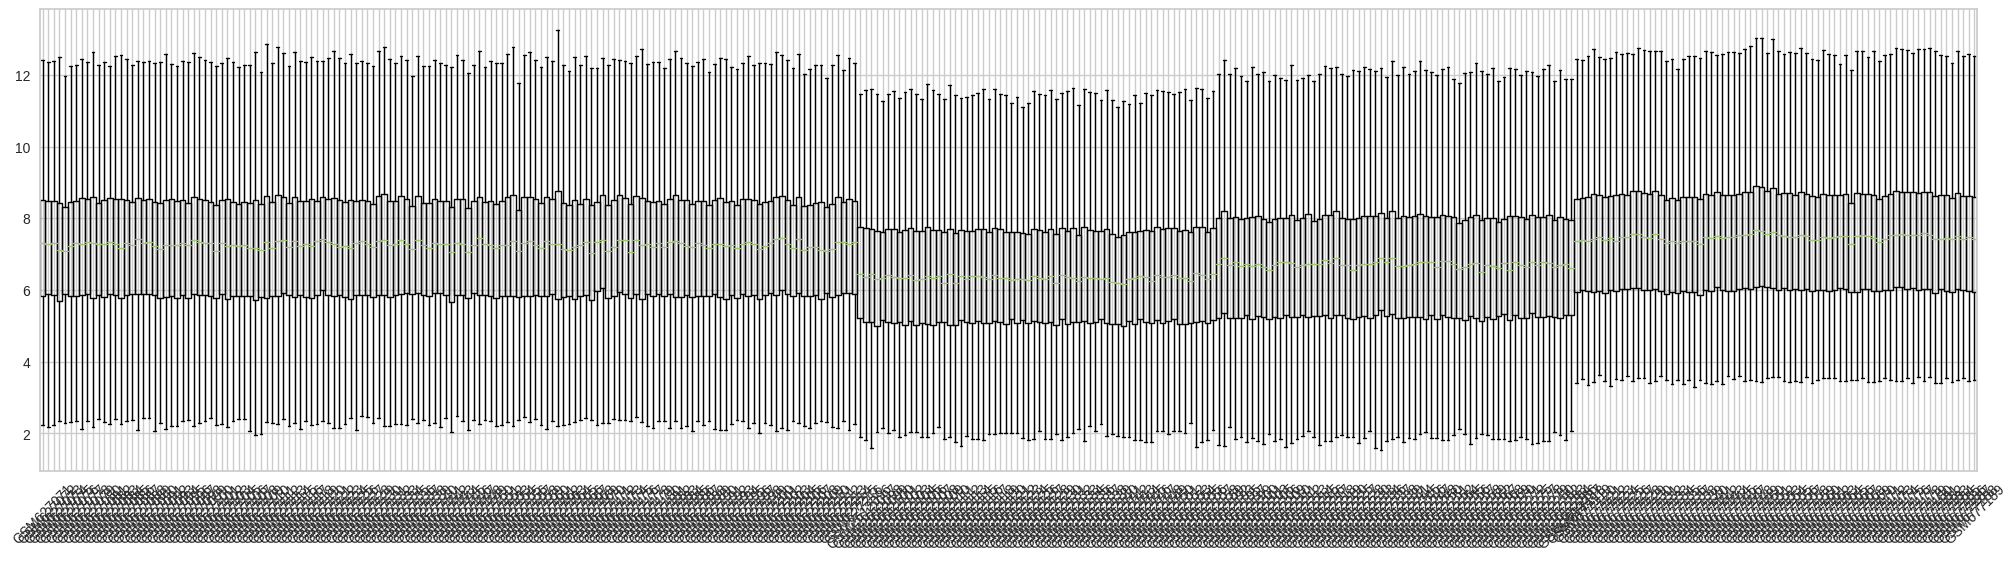

In [12]:
samples = merged_df.select_dtypes(include=[float, int]).T

fig, ax = plt.subplots(figsize=(25, 6))
ax.boxplot(samples, widths=1, showfliers=False)
ax.set_xticks(range(1, len(samples.columns) + 1))
ax.set_xticklabels(samples.columns, rotation = 45)
plt.show()

In [13]:
batch = []
datasets = [asd_df.shape[0], mdd_df.shape[0], scz_df.shape[0]]

for j in range(len(datasets)):
    batch.extend([j for _ in range(datasets[j])])

# run pyComBat
df_corrected = pycombat(samples, batch)

Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


Samples after batch effects correction

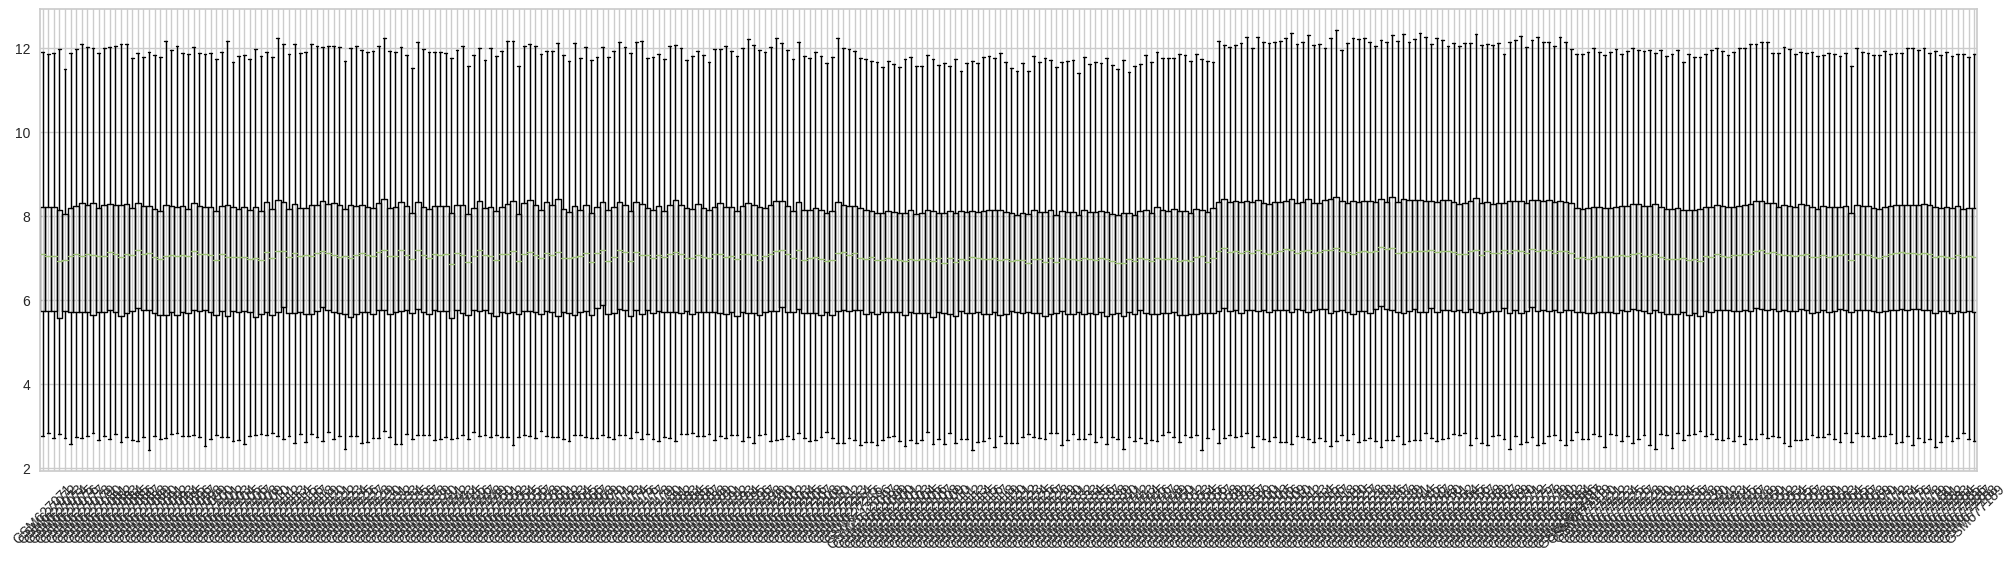

In [14]:
fig, ax = plt.subplots(figsize=(25, 6))
ax.boxplot(df_corrected, widths=1, showfliers=False)
ax.set_xticks(range(1, len(df_corrected.columns) + 1))
ax.set_xticklabels(df_corrected.columns, rotation = 45)
plt.show()

Update the dataframe

In [15]:
merged_df.update(df_corrected.T)
merged_df

ZNF555      CIZ1   SCARNA2     ARIH2    NIF3L1   PLEKHG3   
GSM627071  4.533969  7.932688  4.837319  7.356293  8.308954  6.685334  \
GSM627072  4.711880  7.362170  4.884961  7.166562  8.306135  6.879074   
GSM627073  4.529756  7.486685  4.623689  7.436149  8.311693  7.000403   
GSM627074  4.355531  7.693238  5.123272  6.723975  7.907030  6.943047   
GSM627075  4.636202  7.218309  4.994913  6.898129  8.107088  6.667338   
...             ...       ...       ...       ...       ...       ...   
GSM677185  4.568578  7.598212  5.042243  7.168507  8.203752  6.756023   
GSM677186  4.678186  7.608116  5.020579  7.213376  8.239703  6.837333   
GSM677187  4.331231  7.584514  4.864382  7.011418  8.096886  6.822677   
GSM677188  4.738600  7.603474  5.107399  6.946401  8.189410  6.776621   
GSM677189  4.264846  7.648512  4.900292  6.912985  8.127051  6.818609   

               EDN1    GAREML  CCT6P1 /// CCT6P3    VPS37B  ...   
GSM627071  4.467191  5.064846           8.476621  8.832267  ...  \
GSM627072  4.608258  5.067531           8.238604  8.705287  ...   
GSM627073  4.563542  5.074530           8.444767  8.684856  ...   
GSM627074  4.608404  5.114172           7.769774  8.861869  ...   
GSM627075  4.654304  5.100946           8.336449  8.492289  ...   
...             ...       ...                ...       ...  ...   
GSM677185  4.617211  5.114549           8.291723  8.697694  ...   
GSM677186  4.564396  5.043608           8.306165  8.771410  ...   
GSM677187  4.553749  5.074410           8.296846  8.693092  ...   
GSM677188  4.513528  5.083261           8.301892  8.710599  ...   
GSM677189  4.558083  5.092935           8.278624  8.793155  ...   

           MED24 /// MIR6884    ZNF550     LAIR2   CDK2AP2   C19orf53   
GSM627071           7.371194  6.216072  5.796736  8.649810   9.693062  \
GSM627072           7.035224  6.446223  7.651617  8.306160   9.533150   
GSM627073           6.745833  6.462185  6.116229  8.383487   9.550159   
GSM627074           6.713096  5.469046  6.487541  8.565396   9.444006   
GSM627075           6.702228  6.218283  7.706279  8.331120   9.585949   
...                      ...       ...       ...       ...        ...   
GSM677185           6.896034  6.101686  6.759111  8.596563  10.015449   
GSM677186           6.909129  6.131054  6.390903  8.679664   9.990463   
GSM677187           6.734626  5.943730  6.702511  8.651742   9.869478   
GSM677188           6.795688  6.102699  6.667094  8.666483  10.014901   
GSM677189           6.745306  6.024135  6.576473  8.579492   9.963340   

              TRIM28     MFAP1       MYH9   CCDC88C          class  
GSM627071  10.016170  8.812777  10.499595  7.910563        control  
GSM627072   9.552073  9.016345  10.519488  7.669955        control  
GSM627073   9.442545  8.960138  10.506191  7.921611        control  
GSM627074   9.410334  8.816008  10.652711  7.330813        control  
GSM627075   8.787959  8.849800  10.147631  7.832201        control  
...              ...       ...        ...       ...            ...  
GSM677185   9.743054  8.778332  10.449512  7.820408  schizophrenia  
GSM677186   9.628403  8.865614  10.460176  7.896066  schizophrenia  
GSM677187   9.344664  8.931146  10.227697  7.707991  schizophrenia  
GSM677188   9.614815  8.948318  10.369988  7.876003  schizophrenia  
GSM677189   9.669338  8.789351  10.548689  7.902703  schizophrenia  

[346 rows x 1588 columns]

Extract X & Y

In [16]:
X = merged_df.drop(columns='class').values
y = merged_df['class'].values

Encode labels

In [17]:
le = LabelEncoder()
y = le.fit_transform(y)

Get labels mapping

In [18]:
label_mapping = { le.transform([cl])[0]:cl for cl in le.classes_ }
label_mapping

{0: 'autism', 1: 'control', 2: 'mdd', 3: 'schizophrenia'}

Perform train/test split [2:1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Build the model
Random Forest Classifier

In [20]:
# Define the pipeline
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', RandomForestClassifier()]])

# Define cross-validation strategy
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

# Define the parameter grid to search
param_grid = {
    'classifier__n_estimators': [10, 100, 1000],
    'classifier__max_depth': [None, 3, 7],
    'classifier__min_samples_split': [2, 5, 10]
}

# Perform the grid search
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=stratified_kfold,
                           verbose=1)

grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 1000}


# Model Evaluation

Evaluate the performance of the model on train set using cross-validation

In [21]:
pred_train = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=stratified_kfold)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.64      0.49      0.56        51
           1       0.57      0.79      0.66       103
           2       0.72      0.50      0.59        46
           3       1.00      0.58      0.73        31

    accuracy                           0.64       231
   macro avg       0.73      0.59      0.64       231
weighted avg       0.67      0.64      0.63       231



Evaluate performance of the model on hold-out test set

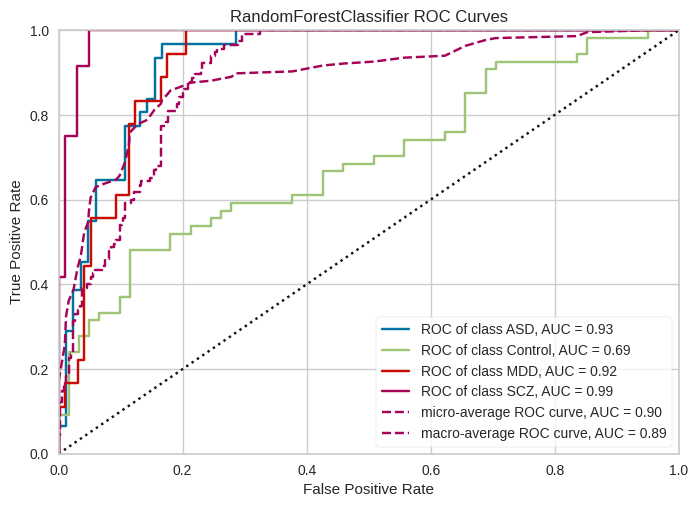

<Axes: title={'center': 'RandomForestClassifier ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [22]:
viz = ROCAUC(grid_search.best_estimator_[1], encoder=['ASD', 'Control', 'MDD', 'SCZ'], title="RandomForestClassifier ROC Curves", micro=True, macro=True)
                                                                       
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

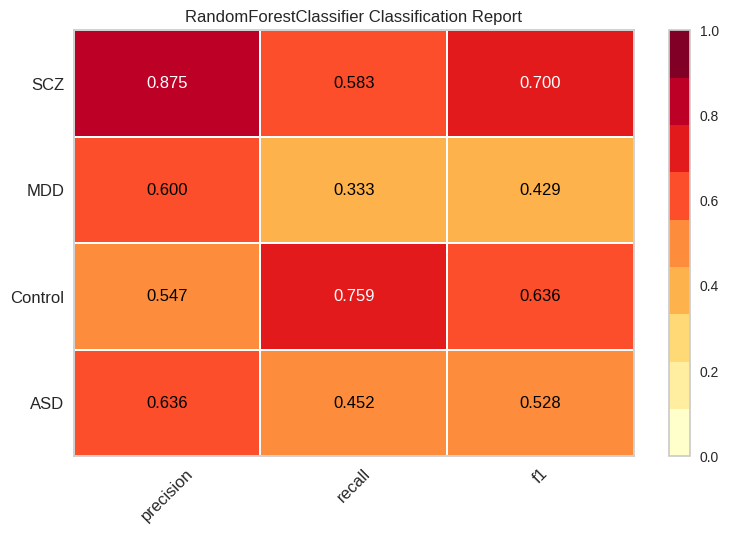

Accuracy: 0.591304347826087


In [24]:
viz = ClassificationReport(grid_search.best_estimator_[1], encoder={0: 'ASD', 1: 'Control', 2: 'MDD', 3: 'SCZ'}, title="RandomForestClassifier Classification Report")

viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

print(f"Accuracy: {viz.score_}")

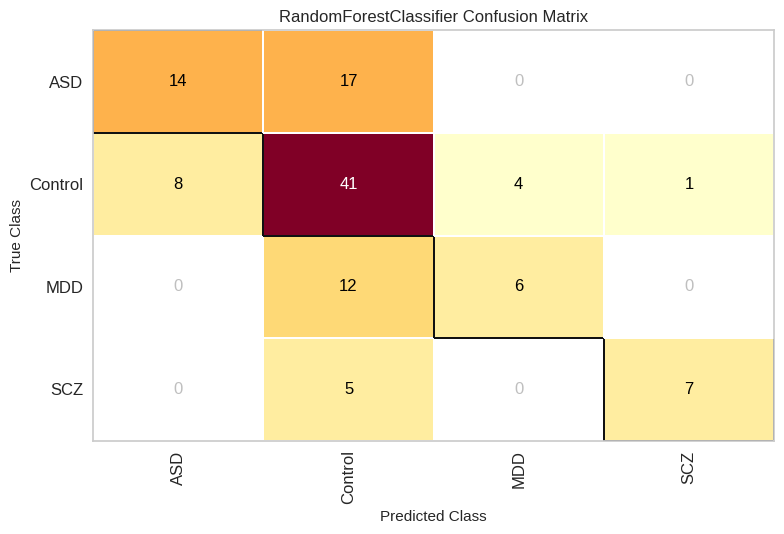

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [26]:
viz = ConfusionMatrix(grid_search.best_estimator_[1], encoder={0: 'ASD', 1: 'Control', 2: 'MDD', 3: 'SCZ'}, title="RandomForestClassifier Confusion Matrix")

viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()